# FFT Block Functionality Test
Author: Tobias G. Zimmer

In [1]:
from pynq import Overlay
from pynq.overlays.base import BaseOverlay
from pynq import allocate
import numpy as np
import matplotlib.pyplot as plt
FFT_MAX_SIZE: int = 1024

In [2]:
overlay = Overlay('FFT_test.bit')

In [3]:
fft_data_dma = overlay.fft_data_dma
fft_config_dma = overlay.fft_config_dma     

In [4]:
fft_data_send_channel = fft_data_dma.sendchannel
fft_data_receive_channel = fft_data_dma.recvchannel
fft_config_send_channel = fft_config_dma.sendchannel

In [5]:
config_tdata_fwd: int = 1024
config_tdata_inv: int = 0

In [6]:
sample_points = np.linspace(0, 1,FFT_MAX_SIZE)
sample_data = 6*np.sin(2*np.pi*500*sample_points, dtype=np.csingle)

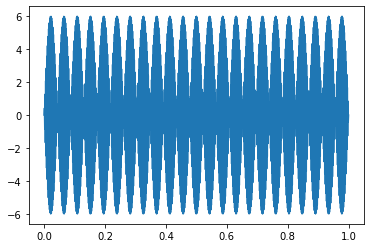

In [7]:
plt.plot(sample_points, np.real(sample_data))

In [8]:
%%time
#Software
software_fft = np.fft.fft(sample_data)
fft_freq = np.fft.fftfreq(FFT_MAX_SIZE, 1/FFT_MAX_SIZE)

CPU times: user 1.55 ms, sys: 0 ns, total: 1.55 ms
Wall time: 1.16 ms


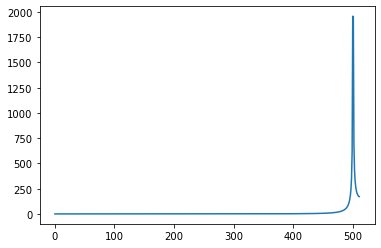

In [9]:
plt.plot(fft_freq[fft_freq>=0], np.abs(software_fft)[fft_freq>=0])

In [10]:
#Hardware
input_buffer = allocate(FFT_MAX_SIZE, dtype=np.csingle)
output_buffer = allocate(FFT_MAX_SIZE, dtype=np.csingle)
np.copyto(input_buffer, sample_data)

In [11]:
%%time
fft_data_send_channel.transfer(input_buffer)
fft_data_receive_channel.transfer(output_buffer)
fft_data_send_channel.wait()
fft_data_receive_channel.wait()

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 2.07 ms


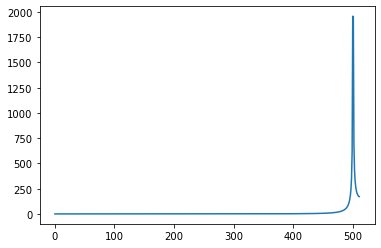

In [12]:
plt.plot(fft_freq[fft_freq>=0], np.abs(output_buffer)[fft_freq>=0])

In [13]:
#FFT Block Config
config_input_buffer = allocate(1, dtype=np.uint16)
#output_buffer_1 = allocate(FFT_MAX_SIZE, dtype=np.csingle)
np.copyto(config_input_buffer, config_tdata_inv)
fft_config_send_channel.transfer(config_input_buffer)
fft_config_send_channel.wait()

In [14]:
np.copyto(input_buffer, output_buffer)
fft_data_send_channel.transfer(input_buffer)
fft_data_receive_channel.transfer(output_buffer)
fft_data_send_channel.wait()
fft_data_receive_channel.wait()

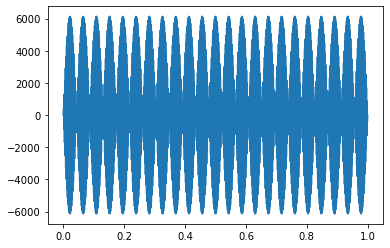

In [15]:
plt.plot(sample_points, np.real(output_buffer))